Printed and electronic copies of *Modeling and Simulation in Python* are available from [No Starch Press](https://nostarch.com/modeling-and-simulation-python) and [Bookshop.org](https://bookshop.org/p/books/modeling-and-simulation-in-python-allen-b-downey/17836697?ean=9781718502161) and [Amazon](https://amzn.to/3y9UxNb).

# Baseball

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    from pint import UnitRegistry
except ImportError:
    !pip install pint
    
# import units
from pint import UnitRegistry
units = UnitRegistry()

In [2]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

In [3]:
# import functions from modsim

from modsim import *

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises. 
Click here to access the notebooks: <https://allendowney.github.io/ModSimPy/>.

In the previous chapter we modeled an object moving in one dimension, with and without drag. Now let's move on to two dimensions, and baseball!

In this chapter we model the flight of a baseball including the effect
of air resistance. In the next chapter we use this model to solve an
optimization problem.

## Baseball

To model the flight of a baseball, we have to make some decisions. To get started, we'll ignore any spin that might be on the ball, and the resulting Magnus force (see <http://modsimpy.com/magnus>). Under this assumption, the ball travels in a vertical plane, so we'll run simulations in two dimensions, rather than three.

To model air resistance, we'll need the mass, frontal area, and drag
coefficient of a baseball. Mass and diameter are easy to find (see
<http://modsimpy.com/baseball>). Drag coefficient is only a little
harder; according to *The Physics of Baseball* (see https://books.google.com/books/about/The_Physics_of_Baseball.html?id=4xE4Ngpk_2EC), the drag coefficient of a baseball is approximately 0.33 (with no units).

However, this value *does* depend on velocity. At low velocities it
might be as high as 0.5, and at high velocities as low as 0.28.
Furthermore, the transition between these values typically happens
exactly in the range of velocities we are interested in, between 20 m/s and 40 m/s.

Nevertheless, we'll start with a simple model where the drag coefficient does not depend on velocity; as an exercise at the end of the chapter, you can implement a more detailed model and see what effect it has on the results.

But first we need a new computational tool, the `Vector` object.

## Vectors

Now that we are working in two dimensions, it will be useful to
work with *vector quantities*, that is, quantities that represent both a magnitude and a direction. We will use vectors to represent positions, velocities, accelerations, and forces in two and three dimensions.

ModSim provides a function called `Vector` that creates a Pandas `Series` that contains the *components* of the vector.
In a `Vector` that represents a position in space, the components are the $x$ and $y$ coordinates in 2-D, plus a $z$ coordinate if the `Vector` is in 3-D.

You can create a `Vector` by specifying its components. The following
`Vector` represents a point 3 units to the right (or east) and 4 units up (or north) from an implicit origin:

In [4]:
A = Vector(3, 4)
show(A)

,component
x,3
y,4


You can access the components of a `Vector` by name using the dot
operator, like this:

In [5]:
A.x

3

In [6]:
A.y

4

You can also access them by index using brackets, like this:

In [7]:
A[0]

3

In [8]:
A[1]

4

`Vector` objects support most mathematical operations, including
addition:

In [9]:
B = Vector(1, 2)
show(A + B)

,component
x,4
y,6


And subtraction:

In [10]:
show(A - B)

,component
x,2
y,2


For the definition and graphical interpretation of these operations, see <http://modsimpy.com/vecops>.

We can specify a `Vector` with coordinates `x` and `y`, as in the previous examples.
Equivalently, we can specify a `Vector` with a magnitude and angle.

*Magnitude* is the length of the vector: if the `Vector` represents a position, magnitude is its distance from the origin; if it represents a velocity, magnitude is its speed.

The *angle* of a `Vector` is its direction, expressed as an angle in radians from the positive $x$ axis. In the Cartesian plane, the angle 0 rad is due east, and the angle $\pi$ rad is due west.

ModSim provides functions to compute the magnitude and angle of a `Vector`.  For example, here are the magnitude and angle of `A`:

In [11]:
mag = vector_mag(A)
theta = vector_angle(A)
mag, theta

(5.0, 0.9272952180016122)

The magnitude is 5 because the length of `A` is the hypotenuse of a 3-4-5 triangle.

The result from `vector_angle` is in radians.
Most Python functions, like `sin` and `cos`, work with radians, 
but many people find it more natural to work with degrees. 
Fortunately, NumPy provides a function to convert radians to degrees:

In [12]:
from numpy import rad2deg

angle = rad2deg(theta)
angle

53.13010235415598

And a function to convert degrees to radians:

In [13]:
from numpy import deg2rad

theta = deg2rad(angle)
theta

0.9272952180016122

To avoid confusion, I'll use the variable name `angle` for a value in degrees and `theta` for a value in radians.

If you are given an angle and magnitude, you can make a `Vector` using
`pol2cart`, which converts from polar to Cartesian coordinates. For example, here's a new `Vector` with the same angle and magnitude of `A`:

In [14]:
x, y = pol2cart(theta, mag)
C = Vector(x, y)
show(C)

,component
x,3.0
y,4.0


Another way to represent the direction of `A` is a *unit vector*,
which is a vector with magnitude 1 that points in the same direction as
`A`. You can compute a unit vector by dividing a vector by its
magnitude:

In [15]:
show(A / vector_mag(A))

,component
x,0.6
y,0.8


ModSim provides a function that does the same thing, called `vector_hat` because unit vectors are conventionally decorated with a hat, like this: $\hat{A}$.

In [16]:
A_hat = vector_hat(A)
show(A_hat)

,component
x,0.6
y,0.8


Now let's get back to the game.

## Simulating Baseball Flight

Let's simulate the flight of a baseball that is batted from home plate
at an angle of 45° and initial speed 40 m/s. We'll use the center of home plate as the origin, a horizontal x-axis (parallel to the ground), and a vertical y-axis (perpendicular to the ground). The initial height is 1 m.

Here's a `Params` object with the parameters we'll need.

In [17]:
params = Params(
    x = 0,          # m
    y = 1,          # m
    angle = 45,     # degree
    speed = 40,  # m / s

    mass = 145e-3,    # kg 
    diameter = 73e-3, # m 
    C_d = 0.33,       # dimensionless

    rho = 1.2,      # kg/m**3
    g = 9.8,        # m/s**2
    t_end = 10,     # s
)

I got the mass and diameter of the baseball from Wikipedia (see <https://en.wikipedia.org/wiki/Baseball_(ball)>) and the coefficient of drag from *The Physics of Baseball* (see <https://books.google.com/books/about/The_Physics_of_Baseball.html?id=4xE4Ngpk_2EC>):
The density of air, `rho`, is based on a temperature of 20 °C at sea level (see <http://modsimpy.com/tempress>). 
As usual, `g` is acceleration due to gravity.
`t_end` is 10 seconds, which is long enough for the ball to land on the ground.

The following function uses these quantities to make a `System` object.

In [18]:
from numpy import pi, deg2rad

def make_system(params):
    
    # convert angle to radians
    theta = deg2rad(params.angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, params.speed)
    
    # make the initial state
    init = State(x=params.x, y=params.y, vx=vx, vy=vy)
    
    # compute the frontal area
    area = pi * (params.diameter/2)**2

    return System(params,
                  init = init,
                  area = area)

`make_system` uses `deg2rad` to convert `angle` to radians and
`pol2cart` to compute the $x$ and $y$ components of the initial
velocity.

`init` is a `State` object with four state variables:

* `x` and `y` are the components of position.

* `vx` and `vy` are the components of velocity.

When we call `System`, we pass `params` as the first argument, which means that the variables in `params` are copied to the new `System` object.

Here's how we make the `System` object.

In [19]:
system = make_system(params)

And here's the initial `State`:

In [20]:
show(system.init)

,state
x,0.000000
y,1.000000
vx,28.284271
vy,28.284271


## Drag Force

Next we need a function to compute drag force:

In [21]:
def drag_force(V, system):
    rho, C_d, area = system.rho, system.C_d, system.area
    
    mag = rho * vector_mag(V)**2 * C_d * area / 2
    direction = -vector_hat(V)
    f_drag = mag * direction
    return f_drag

This function takes `V` as a `Vector` and returns `f_drag` as a
`Vector`. 

* It uses `vector_mag` to compute the magnitude of `V`, 
and the drag equation to compute the magnitude of the drag force, `mag`.

* Then it uses `vector_hat` to compute `direction`, which is a unit vector in the opposite direction of `V`.

* Finally, it computes the drag force vector by multiplying `mag` and `direction`.

We can test it like this:

In [22]:
vx, vy = system.init.vx, system.init.vy
V_test = Vector(vx, vy)
f_drag = drag_force(V_test, system)
show(f_drag)

,component
x,-0.937574
y,-0.937574


The result is a `Vector` that represents the drag force on the baseball, in Newtons, under the initial conditions.

Now we can add drag to the slope function.

In [23]:
def slope_func(t, state, system):
    x, y, vx, vy = state
    mass, g = system.mass, system.g
    
    V = Vector(vx, vy)
    a_drag = drag_force(V, system) / mass
    a_grav = g * Vector(0, -1)
    
    A = a_grav + a_drag
    
    return V.x, V.y, A.x, A.y

As usual, the parameters of the slope function are a time stamp, a `State` object, and a `System` object. 
We don't use `t` in this example, but we can't leave it out because when `run_solve_ivp` calls the slope function, it always provides the same arguments, whether they are needed or not.

`slope_func` unpacks the `State` object into variables `x`, `y`, `vx`, and `vy`.
Then it packs `vx` and `vy` into a `Vector`, which it uses to compute acceleration due to drag, `a_drag`.

To represent acceleration due to gravity, it makes a `Vector` with magnitude `g` in the negative $y$ direction.

The total acceleration of the baseball, `A`, is the sum of accelerations due to gravity and drag.

The return value is a sequence that contains:

* The components of velocity, `V.x` and `V.y`.

* The components of acceleration, `A.x` and `A.y`.

These components represent the slope of the state variables, because `V` is the derivative of position and `A` is the derivative of velocity.

As always, we can test the slope function by running it with the initial conditions:

In [24]:
slope_func(0, system.init, system)

(28.284271247461902, 28.2842712474619, -6.466030881564545, -16.266030881564546)

Using vectors to represent forces and accelerations makes the code
concise, readable, and less error-prone. In particular, when we add
`a_grav` and `a_drag`, the directions are likely to be correct, because they are encoded in the `Vector` objects.

## Adding an Event Function

We're almost ready to run the simulation.  The last thing we need is an event function that stops when the ball hits the ground.

In [25]:
def event_func(t, state, system):
    x, y, vx, vy = state
    return y

The event function takes the same parameters as the slope function, and returns the $y$ coordinate of position. When the $y$ coordinate passes through 0, the simulation stops.

As we did with `slope_func`, we can test `event_func` with the initial conditions.

In [26]:
event_func(0, system.init, system)

1.0

Here's how we run the simulation with this event function:

In [27]:
results, details = run_solve_ivp(system, slope_func,
                                 events=event_func)
details.message

'A termination event occurred.'

The message indicates that a "termination event" occurred; that is, the simulated ball reached the ground.

`results` is a `TimeFrame` with one row for each time step and one column for each of the state variables.
Here are the last few rows.

In [28]:
results.tail()

,x,y,vx,vy
4.804692,96.438515,4.284486,14.590855,-20.726780
4.854740,97.166460,3.238415,14.484772,-21.065476
4.904789,97.889087,2.175515,14.378566,-21.400392
4.954838,98.606374,1.095978,14.272264,-21.731499
5.004887,99.318296,0.000000,14.165894,-22.058763


We can get the flight time like this:

In [29]:
flight_time = results.index[-1]
flight_time

5.004887034868346

And the final state like this:

In [30]:
final_state = results.iloc[-1]
show(final_state)

,5.004887
x,99.318296
y,0.000000
vx,14.165894
vy,-22.058763


The final value of `y` is close to 0, as it should be.  The final value of `x` tells us how far the ball flew, in meters.

In [31]:
x_dist = final_state.x
x_dist

99.31829628352207

We can also get the final velocity, like this:

In [32]:
final_V = Vector(final_state.vx, final_state.vy)
show(final_V)

,component
x,14.165894
y,-22.058763


The magnitude of final velocity is the speed of the ball when it lands.

In [33]:
vector_mag(final_V)

26.215674453237572

The final speed is about 26 m/s, which is substantially slower than the initial speed, 40 m/s.

## Visualizing Trajectories

To visualize the results, we can plot the $x$ and $y$ components of position like this:

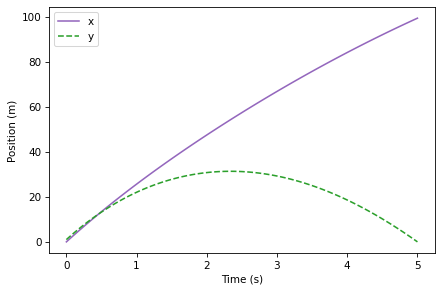

In [34]:
results.x.plot(color='C4')
results.y.plot(color='C2', style='--')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

As expected, the $x$ component increases as the ball moves away from home plate. The $y$ position climbs initially and then descends, falling to 0 m near 5.0 s.

Another way to view the results is to plot the $x$ component on the
$x$-axis and the $y$ component on the $y$-axis, so the plotted line follows the trajectory of the ball through the plane:

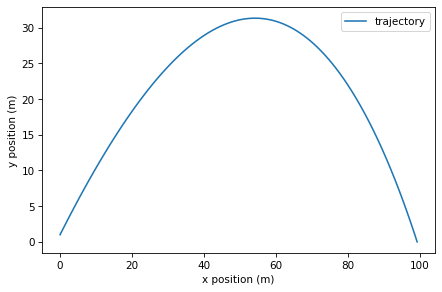

In [35]:
def plot_trajectory(results):
    x = results.x
    y = results.y
    make_series(x, y).plot(label='trajectory')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)')

plot_trajectory(results)

This way of visualizing the results is called a *trajectory plot* (see <http://modsimpy.com/trajec>).
A trajectory plot can be easier to interpret than a time series plot,
because it shows what the motion of the projectile would look like (at
least from one point of view). Both plots can be useful, but don't get
them mixed up! If you are looking at a time series plot and interpreting it as a trajectory, you will be very confused.

Notice that the trajectory is not symmetric.
With a launch angle of 45°, the landing angle is closer to vertical, about 57° degrees.

In [36]:
rad2deg(vector_angle(final_V))

-57.29187097821225

## Animating the Baseball

One of the best ways to visualize the results of a physical model is animation.  If there are problems with the model, animation can make them apparent.

The ModSimPy library provides `animate`, which takes as parameters a `TimeSeries` and a draw function.
The draw function should take as parameters a time stamp and a `State`.  It should draw a single frame of the animation.

In [37]:
from matplotlib.pyplot import plot

xlim = results.x.min(), results.x.max()
ylim = results.y.min(), results.y.max()

def draw_func(t, state):
    plot(state.x, state.y, 'bo')
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=xlim,
             ylim=ylim)

Inside the draw function, should use `decorate` to set the limits of the $x$ and $y$ axes.
Otherwise `matplotlib` auto-scales the axes, which is usually not what you want.

Now we can run the animation like this:

```
animate(results, draw_func)
```

You can see the results when you run the code from this chapter.

To run the animation, uncomment the following line of code and run the cell.

In [38]:
# animate(results, draw_func)

## Summary

This chapter introduces `Vector` objects, which we use to represent position, velocity, and acceleration in two dimensions.
We also represent forces using vectors, which make it easier to add up forces acting in different directions.

Our ODE solver doesn't work with `Vector` objects, so it takes some work to pack and unpack their components.
Nevertheless, we were able to run simulations with vectors and display the results.

In the next chapter we'll use these simulations to solve an optimization problem.

## Exercises

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises. 
You can access the notebooks at <https://allendowney.github.io/ModSimPy/>.

### Exercise 1

 Run the simulation with and without air resistance.  How wrong would we be if we ignored drag?

In [39]:
# Hint

system2 = make_system(params.set(C_d=0))

In [40]:
# Solution

results2, details2 = run_solve_ivp(system2, slope_func, 
                                   events=event_func)
details.message

'A termination event occurred.'

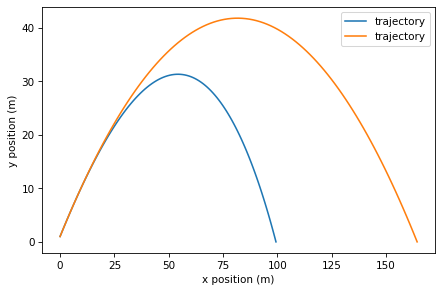

In [41]:
# Solution

plot_trajectory(results)
plot_trajectory(results2)

In [42]:
# Solution

x_dist2 = results2.iloc[-1].x
x_dist2

164.2592550241319

In [43]:
# Solution

x_dist2 - x_dist

64.94095874060983

### Exercise 2

The baseball stadium in Denver, Colorado is 1,580 meters above sea level, where the density of air is about 1.0 kg / m$^3$.  Compared with the example near sea level, how much farther would a ball travel if hit with the same initial speed and launch angle?

In [44]:
# Hint

system3 = make_system(params.set(rho=1.0))

In [45]:
# Solution

results3, details3 = run_solve_ivp(system3, slope_func, 
                                   events=event_func)

x_dist3 = results3.iloc[-1].x
x_dist3

105.78838005859785

In [46]:
# Solution

x_dist3 - x_dist

6.4700837750757785

### Exercise 3

 The model so far is based on the assumption that coefficient of drag does not depend on velocity, but in reality it does.  The following figure, from Adair, *The Physics of Baseball*, shows coefficient of drag as a function of velocity (see <https://books.google.com/books/about/The_Physics_of_Baseball.html?id=4xE4Ngpk_2EC>).

![Graph of drag coefficient versus velocity](https://github.com/AllenDowney/ModSimPy/raw/master/figs/baseball_drag.png)

I used an online graph digitizer (<https://automeris.io/WebPlotDigitizer>) to extract the data and save it in a CSV file.  

The following cell downloads the data file.

In [47]:
download('https://github.com/AllenDowney/ModSim/raw/main/data/' +
         'baseball_drag.csv')

We can use Pandas to read it.

In [48]:
from pandas import read_csv

baseball_drag = read_csv('baseball_drag.csv')

Here are the first few rows.

In [49]:
baseball_drag.head()

,Velocity in mph,Drag coefficient
0,0.058486,0.49965
1,19.845000,0.49878
2,39.476000,0.49704
3,50.181000,0.48225
4,60.134000,0.45004


I'll use Pint to convert miles per hour to meters per second.

In [50]:
mph_to_mps = (1 * units.mph).to(units.m/units.s).magnitude
speed = baseball_drag['Velocity in mph'] * mph_to_mps

I'll put the results in a `Series`.

In [51]:
C_d_series = make_series(speed, baseball_drag['Drag coefficient'])

Here's what it looks like.

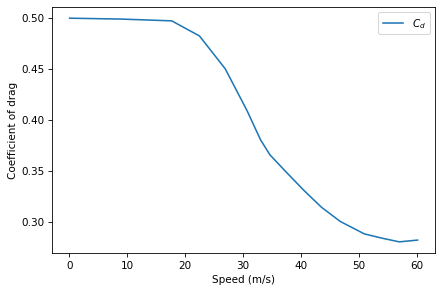

In [64]:
C_d_series.plot(label='$C_d$')
decorate(xlabel='Speed (m/s)', 
         ylabel='Coefficient of drag')

And, for use in the slope function, we can make a function that interpolates the data.

In [53]:
drag_interp = interpolate(C_d_series)
drag_interp(30)

array(0.41607879)

Modify the model to include the dependence of `C_d` on velocity, and see how much it affects the results.

In [54]:
# Solution

def drag_force2(V, system):
    rho, area = system.rho, system.area
    
    C_d = drag_interp(vector_mag(V))
    mag = -rho * vector_mag(V)**2 * C_d * area / 2
    direction = vector_hat(V)
    f_drag = direction * mag
    return f_drag

In [55]:
# Solution

def slope_func2(t, state, system):
    x, y, vx, vy = state
    mass, g = system.mass, system.g
    
    V = Vector(vx, vy)
    a_drag = drag_force2(V, system) / mass
    a_grav = g * Vector(0, -1)
    
    A = a_grav + a_drag
    
    return V.x, V.y, A.x, A.y

In [56]:
# Solution

system4 = make_system(params)

In [57]:
# Solution

V = Vector(30, 30)
f_drag = drag_force(V, system4)
show(f_drag)

,component
x,-1.054771
y,-1.054771


In [58]:
# Solution

slope_func(0, system4.init, system4)

(28.284271247461902, 28.2842712474619, -6.466030881564545, -16.266030881564546)

In [59]:
# Solution

results4, details4 = run_solve_ivp(system4, slope_func2, 
                                   events=event_func)
details4.message

'A termination event occurred.'

In [60]:
# Solution

results4.tail()

,x,y,vx,vy
4.722631,87.869695,3.989943e+00,12.094833,-19.677696
4.771825,88.462327,3.013834e+00,11.980462,-19.973270
4.821019,89.049363,2.023337e+00,11.866567,-20.265039
4.870213,89.630803,1.018656e+00,11.753207,-20.553016
4.919407,90.206647,1.065814e-14,11.640440,-20.837214


In [61]:
# Solution

x_dist4 = results4.iloc[-1].x
x_dist4

90.20664656623305

In [62]:
# Solution

# Taking into account variation in C_d, the ball
# would travel about 9 m less far.

x_dist4 - x_dist

-9.111649717289026